# 암환자 유전체 데이터 기반 암종 분류 AI 모델 개발


# library loading

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from sklearn.metrics import f1_score

# macro f1 score 함수
def macro_f1_score(y_true, y_pred, n_classes = 25):
    f1_scores = []
    for c in range(n_classes):
        y_true_c = (y_true == c)
        y_pred_c = (y_pred == c)
        f1_c = f1_score(y_true_c, y_pred_c)
        f1_scores.append(f1_c)
    return np.mean(f1_scores)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -qq '/content/drive/MyDrive/0000/dacon_biodata/open.zip'

# data loading

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [9]:
train.tail(5)

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
6196,TRAIN_6196,LUAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6197,TRAIN_6197,LGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6198,TRAIN_6198,COAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,T181S,WT
6199,TRAIN_6199,TGCT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6200,TRAIN_6200,SKCM,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [5]:
test.head(5)

,ID,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TEST_0000,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TEST_0001,WT,WT,WT,WT,WT,R587Q,WT,WT,WT,...,WT,WT,WT,WT,WT,I383Sfs,WT,WT,WT,WT
2,TEST_0002,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TEST_0003,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TEST_0004,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


# preprocessing

### 유전체 동의성 변이

In [11]:
# 정규 표현식 regular expression 모듈
import re

# 패턴을 구분하는 함수 정의
def process_value(value):
    # 먼저 value가 문자열인지 확인 (float나 다른 타입의 값 처리)
    if not isinstance(value, str):
        return value  # 문자열이 아닌 경우 그대로 반환

    # 1) WT 그대로 유지
    if value == 'WT':
        return value

    # 2) 복합 패턴 처리를 위한 split
    parts = value.split()  # 공백 기준
    processed_parts = []

    for part in parts:
        # 숫자 앞뒤로 같은 패턴이 있는지 확인
        match = re.match(r'([A-Za-z]+)(\d+)([A-Za-z]+)', part)
        if match:
            prefix, number, suffix = match.groups()
            # 앞뒤 문자가 같다면 해당 부분 무시
            if prefix == suffix:
                continue
        processed_parts.append(part)

    # 처리된 부분이 없으면 WT로 변경
    return 'WT' if not processed_parts else ' '.join(processed_parts)


In [7]:
# train 데이터프레임 전처리
for col in train.columns[2:]:  # ID와 SUBCLASS 제외
    train[col] = train[col].apply(process_value)

# 최종 데이터 확인
train.head()

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TRAIN_0000,KIPAN,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TRAIN_0001,SARC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2,TRAIN_0002,SKCM,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TRAIN_0003,KIRC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TRAIN_0004,GBMLGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [12]:
# test 데이터프레임 전처리
for col in test.columns[2:]:  # ID와 SUBCLASS 제외
    test[col] = test[col].apply(process_value)

# 최종 데이터 확인
test.head()

,ID,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TEST_0000,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TEST_0001,WT,WT,WT,WT,WT,R587Q,WT,WT,WT,...,WT,WT,WT,WT,WT,I383Sfs,WT,WT,WT,WT
2,TEST_0002,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TEST_0003,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TEST_0004,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


### 변이 횟수 파생변수 생성

In [16]:
# 변이 횟수를 계산하는 함수 정의
def count_mutations(row):
    mutation_count = 0
    for val in row:
        # 먼저 val이 문자열인지 확인
        if isinstance(val, str):
            if val != 'WT':
                # 공백으로 나누어진 패턴 개수를 모두 더하기
                mutation_count += len(val.split())
        else:
            # 문자열이 아니면 변이로 간주하지 않음
            continue
    return mutation_count


In [17]:
# 각 ID별로 변이 횟수 측정하여 새로운 열 추가
train['mutation_cnt'] = train.iloc[:, 2:].apply(count_mutations, axis=1)

# 최종 데이터 확인
train

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX,mutation_cnt
0,TRAIN_0000,KIPAN,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,18
1,TRAIN_0001,SARC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,12
2,TRAIN_0002,SKCM,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,85
3,TRAIN_0003,KIRC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,4
4,TRAIN_0004,GBMLGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,TRAIN_6196,LUAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,33
6197,TRAIN_6197,LGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,8
6198,TRAIN_6198,COAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,T181S,WT,13
6199,TRAIN_6199,TGCT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,5


In [18]:
# 각 ID별로 변이 횟수 측정하여 새로운 열 추가
test['mutation_cnt'] = test.iloc[:, 2:].apply(count_mutations, axis=1)

# 최종 데이터 확인
test

,ID,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,...,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX,mutation_cnt
0,TEST_0000,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,81
1,TEST_0001,WT,WT,WT,WT,WT,R587Q,WT,WT,WT,...,WT,WT,WT,WT,I383Sfs,WT,WT,WT,WT,523
2,TEST_0002,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,5
3,TEST_0003,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,6
4,TEST_0004,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,TEST_2541,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,90
2542,TEST_2542,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,11
2543,TEST_2543,WT,WT,WT,WT,WT,L217I,WT,R5M,G606D,...,L232R,WT,WT,WT,WT,N252I N251I,G679V,WT,WT,2231
2544,TEST_2544,WT,WT,WT,WT,WT,WT,WT,WT,R1517H,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,4


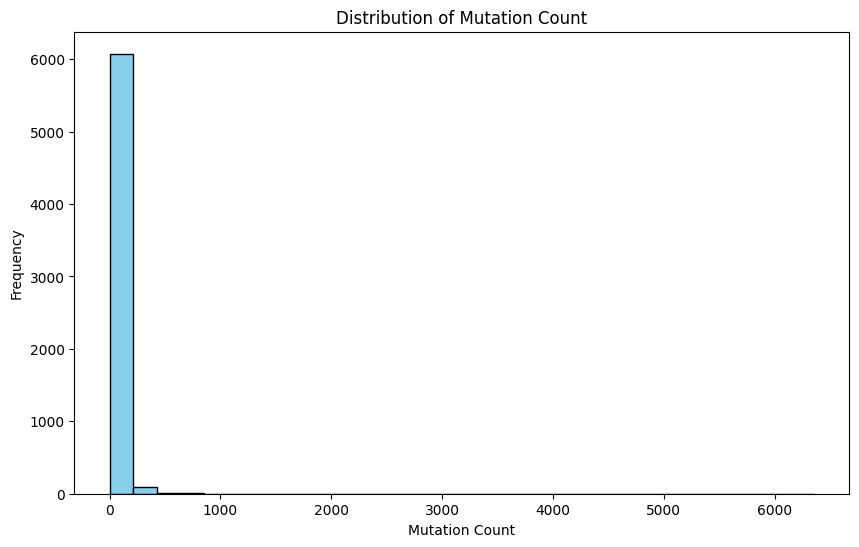

In [19]:
import matplotlib.pyplot as plt

# mutation_count 분포를 막대그래프로 시각화
plt.figure(figsize=(10, 6))
train['mutation_cnt'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')

# 그래프 제목 및 라벨 설정
plt.title('Distribution of Mutation Count')
plt.xlabel('Mutation Count')
plt.ylabel('Frequency')

# 그래프 출력
plt.show()

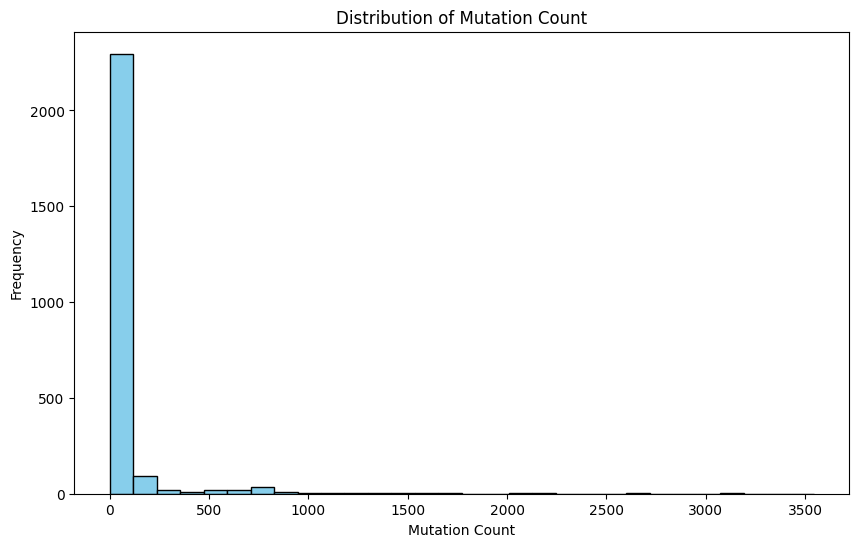

In [20]:
import matplotlib.pyplot as plt

# mutation_count 분포를 막대그래프로 시각화
plt.figure(figsize=(10, 6))
test['mutation_cnt'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')

# 그래프 제목 및 라벨 설정
plt.title('Distribution of Mutation Count')
plt.xlabel('Mutation Count')
plt.ylabel('Frequency')

# 그래프 출력
plt.show()

In [23]:
# SUBCLASS별 mutation_count의 평균 계산
train_mutation_count = pd.DataFrame(train.groupby('SUBCLASS')['mutation_cnt'].mean())
train_mutation_count.sort_values(by='mutation_cnt', ascending=True)

,mutation_cnt
SUBCLASS,
LAML,2.563291
PCPG,3.428571
THCA,3.435185
THYM,3.693878
PRAD,6.030075
LGG,7.109170
GBMLGG,9.904555
SARC,10.358586
KIRC,10.497006


### LabelEncoder

In [25]:
# SUBCLASS 가 범주형이기 때문에 LabelEncoder 사용
le_subclass = LabelEncoder()
train['SUBCLASS'] = le_subclass.fit_transform(train['SUBCLASS'])

# 변환된 레이블 확인
for i, label in enumerate(le_subclass.classes_):
    print(f"원래 레이블: {label}, 변환된 숫자: {i}")

원래 레이블: ACC, 변환된 숫자: 0
원래 레이블: BLCA, 변환된 숫자: 1
원래 레이블: BRCA, 변환된 숫자: 2
원래 레이블: CESC, 변환된 숫자: 3
원래 레이블: COAD, 변환된 숫자: 4
원래 레이블: DLBC, 변환된 숫자: 5
원래 레이블: GBMLGG, 변환된 숫자: 6
원래 레이블: HNSC, 변환된 숫자: 7
원래 레이블: KIPAN, 변환된 숫자: 8
원래 레이블: KIRC, 변환된 숫자: 9
원래 레이블: LAML, 변환된 숫자: 10
원래 레이블: LGG, 변환된 숫자: 11
원래 레이블: LIHC, 변환된 숫자: 12
원래 레이블: LUAD, 변환된 숫자: 13
원래 레이블: LUSC, 변환된 숫자: 14
원래 레이블: OV, 변환된 숫자: 15
원래 레이블: PAAD, 변환된 숫자: 16
원래 레이블: PCPG, 변환된 숫자: 17
원래 레이블: PRAD, 변환된 숫자: 18
원래 레이블: SARC, 변환된 숫자: 19
원래 레이블: SKCM, 변환된 숫자: 20
원래 레이블: STES, 변환된 숫자: 21
원래 레이블: TGCT, 변환된 숫자: 22
원래 레이블: THCA, 변환된 숫자: 23
원래 레이블: THYM, 변환된 숫자: 24
원래 레이블: UCEC, 변환된 숫자: 25


# Test - NA

In [67]:
test.isnull().sum().unique()

array([ 0, 29,  1,  2, 77, 21,  3, 19,  4, 65])

In [66]:
# 결측치가 있는 열(Column)만 추출
missing_columns = test.columns[test.isnull().any()].tolist()

# 결측치가 있는 열 출력
missing_columns

['AK2',
 'ATP6V1H',
 'CCRL2',
 'CFP',
 'CNOT2',
 'CRAT',
 'DPYSL4',
 'GUK1',
 'IER3',
 'INHBB',
 'KCNH1',
 'MYL1',
 'NDUFV1',
 'NUDT4',
 'POLD2',
 'PTCH1',
 'PTGES3',
 'RBM5',
 'SCAMP1',
 'SCNN1A',
 'SLC25A28',
 'SYBU',
 'TARS1',
 'TMEM97',
 'TNFAIP6']

In [68]:
test[missing_columns]

,AK2,ATP6V1H,CCRL2,CFP,CNOT2,CRAT,DPYSL4,GUK1,IER3,INHBB,...,PTCH1,PTGES3,RBM5,SCAMP1,SCNN1A,SLC25A28,SYBU,TARS1,TMEM97,TNFAIP6
0,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,WT,WT,WT,WT,WT,WT,R124Q,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2542,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2543,WT,WT,V168M V180M,M136I,NaN,WT,WT,WT,WT,WT,...,E44G,WT,NaN,WT,Y478H Y455H Y514H,P15Afs,V87A V84A V86A,WT,K176delinsNEGNNHWPRVEMPTGWLLVGYNTRNTAQNPRLQQHL...,NaN
2544,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [70]:
# WT가 아닌 값들만 필터링
non_wt_values_test = test[missing_columns].replace('WT', np.nan).dropna(how='all')

non_wt_values_test

,AK2,ATP6V1H,CCRL2,CFP,CNOT2,CRAT,DPYSL4,GUK1,IER3,INHBB,...,PTCH1,PTGES3,RBM5,SCAMP1,SCNN1A,SLC25A28,SYBU,TARS1,TMEM97,TNFAIP6
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,R124Q,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,A36P,NaN,NaN,A6G,A460G,NaN,NaN,NaN,NaN,NaN,...,N49K,NaN,NaN,E100Q E74Q,NaN,NaN,E427D E309D E265D E428D E298D E425D,E706Q E739Q,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,L427M,NaN,NaN,NaN,...,R550X R536X R601X R451X R602X,S2P,NaN,A273T A247T,T240A T263A T299A,NaN,E179K E339K E341K E223K E342K E212K,R696X R663X,I22T,NaN
27,NaN,NaN,NaN,NaN,NaN,R575C R570C R591C R615C R616C R594C,N533S,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2523,NaN,NaN,NaN,NaN,NaN,M23I M1I M22I,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,M1R,NaN,NaN,NaN,NaN
2531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K106Gfs K85Gfs,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2534,NaN,NaN,NaN,T156A,NaN,NaN,NaN,NaN,NaN,NaN,...,S1033R S967R S1032R S981R S882R,NaN,NaN,NaN,F640L F676L F617L,NaN,V41L V40L V38L,A351G A318G,NaN,NaN
2536,Y193F Y201F Y159F Y153F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,M1R,NaN,NaN,NaN,NaN


# Model - xgb

In [26]:
# x 의 경우도 범주형으로 구성되어 있어, 알맞은 인코딩 필요
X = train.drop(columns=['SUBCLASS', 'ID'])
y_subclass = train['SUBCLASS']

categorical_columns = X.select_dtypes(include=['object', 'category']).columns
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_encoded = X.copy()
X_encoded[categorical_columns] = ordinal_encoder.fit_transform(X[categorical_columns])

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y_subclass, test_size=0.2, random_state=42)

In [30]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

In [31]:
xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)])

[0]	validation_0-mlogloss:2.97557	validation_1-mlogloss:3.01257
[1]	validation_0-mlogloss:2.80281	validation_1-mlogloss:2.86827
[2]	validation_0-mlogloss:2.66934	validation_1-mlogloss:2.75842
[3]	validation_0-mlogloss:2.56006	validation_1-mlogloss:2.67386
[4]	validation_0-mlogloss:2.46702	validation_1-mlogloss:2.59909
[5]	validation_0-mlogloss:2.38504	validation_1-mlogloss:2.53698
[6]	validation_0-mlogloss:2.31328	validation_1-mlogloss:2.48295
[7]	validation_0-mlogloss:2.24801	validation_1-mlogloss:2.43642
[8]	validation_0-mlogloss:2.18962	validation_1-mlogloss:2.39292
[9]	validation_0-mlogloss:2.13675	validation_1-mlogloss:2.35681
[10]	validation_0-mlogloss:2.08824	validation_1-mlogloss:2.32418
[11]	validation_0-mlogloss:2.04330	validation_1-mlogloss:2.29563
[12]	validation_0-mlogloss:2.00198	validation_1-mlogloss:2.26947
[13]	validation_0-mlogloss:1.96337	validation_1-mlogloss:2.24368
[14]	validation_0-mlogloss:1.92722	validation_1-mlogloss:2.22230
[15]	validation_0-mlogloss:1.89428	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

## Inference

In [32]:
test_X = test.drop(columns=['ID'])
X_encoded = test_X.copy()
X_encoded[categorical_columns] = ordinal_encoder.transform(test_X[categorical_columns])

In [33]:
predictions = xgb_model.predict(X_encoded)

In [34]:
original_labels = le_subclass.inverse_transform(predictions)

## prediction

In [38]:
submission["SUBCLASS"] = original_labels
submission.to_csv('./xgb_submission.csv', encoding='UTF-8-sig', index=False)

# Model - catboost

In [40]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00


In [54]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    loss_function='MultiClass',
    custom_metric=['MultiClass', 'AUC', 'F1'],
    eval_metric = 'MultiClass',

    iterations=1000,
    learning_rate=0.1,
    random_seed=42,

    depth=6,
    grow_policy='Depthwise',
    auto_class_weights='SqrtBalanced',
  #  cat_features=list(train.SUBCLASS.unique()),  # 범주형 특징 인덱스


    verbose=True,
    early_stopping_rounds=50,
    task_type="GPU"
)

# 모델 학습
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))


# 최적 모델 저장
model.save_model('best_model.cbm')

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 3.0053369	test: 3.0337007	best: 3.0337007 (0)	total: 355ms	remaining: 5m 54s
1:	total: 501ms	remaining: 4m 9s
2:	total: 638ms	remaining: 3m 31s
3:	total: 776ms	remaining: 3m 13s
4:	total: 893ms	remaining: 2m 57s
5:	learn: 2.5652288	test: 2.6380917	best: 2.6380917 (5)	total: 1.08s	remaining: 2m 59s
6:	total: 1.22s	remaining: 2m 53s
7:	total: 1.34s	remaining: 2m 46s
8:	total: 1.45s	remaining: 2m 39s
9:	total: 1.57s	remaining: 2m 35s
10:	learn: 2.3669613	test: 2.4537276	best: 2.4537276 (10)	total: 1.76s	remaining: 2m 38s
11:	total: 1.91s	remaining: 2m 37s
12:	total: 2s	remaining: 2m 31s
13:	total: 2.08s	remaining: 2m 26s
14:	total: 2.21s	remaining: 2m 25s
15:	learn: 2.2660627	test: 2.3664199	best: 2.3664199 (15)	total: 2.38s	remaining: 2m 26s
16:	total: 2.47s	remaining: 2m 22s
17:	total: 2.58s	remaining: 2m 20s
18:	total: 2.65s	remaining: 2m 17s
19:	total: 2.75s	remaining: 2m 14s
20:	learn: 2.2108670	test: 2.3206814	best: 2.3206814 (20)	total: 2.94s	remaining: 2m 17s
21:	total: 

In [55]:
test_X = test.drop(columns=['ID'])
X_encoded = test_X.copy()
X_encoded[categorical_columns] = ordinal_encoder.transform(test_X[categorical_columns])

In [56]:
predictions = model.predict(X_encoded)

In [57]:
original_labels = le_subclass.inverse_transform(predictions)

In [58]:
submission["SUBCLASS"] = original_labels
submission.to_csv('./cat_submission.csv', encoding='UTF-8-sig', index=False)

# Model - RandomForest

In [74]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤 포레스트 모델 정의
rf_model = RandomForestClassifier(
    n_estimators=1000,
    max_depth=10,
    random_state=42,
)

# 모델 학습
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=42)

In [75]:
test_X = test.drop(columns=['ID'])
X_encoded = test_X.copy()
X_encoded[categorical_columns] = ordinal_encoder.transform(test_X[categorical_columns])

In [76]:
predictions = rf_model.predict(X_encoded)

In [77]:
original_labels = le_subclass.inverse_transform(predictions)

In [78]:
submission["SUBCLASS"] = original_labels
submission.to_csv('./rf_submission.csv', encoding='UTF-8-sig', index=False)